# Ch. 4 - A deeper network & Overfitting
In this chapter we will build a neural network with a hidden layer to fit a more complex function. First, what makes a neural network 'deep'? The number of layers. In a neural network we can stack layers on top of each other. The more layers, the deeper the network. In the last chapters, we built a 1 layer neural network (the input layer does not count), which is the same as a logistic regressor. In this chapter we will add a so called 'hidden layer'. A hidden layer is a layer that sits between the input and the output.

![2 Layer NN](https://storage.googleapis.com/aibootcamp/Week%201/assets/2_layer_nn.jpg)

But before we do anything, let's quickly load some libraries needed for the code below

In [1]:
# Package imports
# Matplotlib is a matlab like plotting library
import matplotlib
import matplotlib.pyplot as plt
# Numpy handles matrix operations
import numpy as np
# SciKitLearn is a useful machine learning utilities library
import sklearn
# The sklearn dataset module helps generating datasets
import sklearn.datasets
import sklearn.linear_model


# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
# Just some helper functions we moved over from the last chapter
# sigmoid function
def sigmoid(x):
    '''
    Calculates the sigmoid activation of a given input x
    See: https://en.wikipedia.org/wiki/Sigmoid_function
    '''
    return 1/(1+np.exp(-x))

#Log Loss function
def log_loss(y,y_hat):
    '''
    Calculates the logistic loss between a prediction y_hat and the labels y
    See: http://wiki.fast.ai/index.php/Log_Loss

    We need to clip values that get too close to zero to avoid zeroing out. 
    Zeroing out is when a number gets so small that the computer replaces it with 0.
    Therefore, we clip numbers to a minimum value.
    '''
    minval = 0.000000000001
    N = y.shape[0]
    l = -1/N * np.sum(y * np.log(y_hat.clip(min=minval)) + (1-y) * np.log((1-y_hat).clip(min=minval)))
    return l

# Log loss derivative
def log_loss_derivative(y,y_hat):
    '''
    Calculates the gradient (derivative) of the log loss between point y and y_hat
    See: https://stats.stackexchange.com/questions/219241/gradient-for-logistic-loss-function
    '''
    return (y_hat-y)

## Forward propagation through a 2 layer network
Propagating through a 2 layer network is very similar to propagating through a 1 layer network. In the first step we multiply the input with the weights of the first layer:

$$z_1 = A_0.W_1 + b_1$$

To obtain the activation $A_1$ we then again pass $z_1$ through an activation function. This time it is a [hyperbolic tangent or tanh function](https://en.wikipedia.org/wiki/Hyperbolic_function). tanh works a lot like sigmoid except that it can output negative values, too. There has been a lot of research on different activation functions for hidden layer. The most commonly used one today is [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), we will use tanh in this chapter since it is still a very useful function and makes explaining some broader concepts easier.

![tanh](https://storage.googleapis.com/aibootcamp/Week%201/assets/TanhReal.gif)

The tanh function is
$$tanh(x) = \frac{e^{2*x}-1}{e^{2x}+1}$$
So
$$A_1 = tanh(z_1)$$
This activation is then the basis for the calculation of $z_2$
$$z_2 = A_1.W_2 + b_2$$
The output $A_2$ is then again calculated with the sigmoid function
$$A_2 = \sigma(z_2)$$

In python code it looks like this:

In [3]:
def forward_prop(model,a0):
    '''
    Forward propagates through the model, stores results in cache.
    See: https://stats.stackexchange.com/questions/147954/neural-network-forward-propagation
    A0 is the activation at layer zero, it is the same as X
    '''
    
    # Load parameters from model
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Linear step
    z1 = a0.dot(W1) + b1
    
    # First activation function
    a1 = np.tanh(z1)
    
    # Second linear step
    z2 = a1.dot(W2) + b2
    
    # Second activation function
    a2 = sigmoid(z2)
    cache = {'a0':a0,'z1':z1,'a1':a1,'z1':z1,'a2':a2}
    return cache

## Backward propagation through a 2 layer neural network
Backward propagation through a 2 layer neural network is also very similar to a 1 layer neural net. First we calculate the derivative of the loss function:

$$dz_2 = (A_2 - y)$$

Then we calculate the derivative of the loss function with respect to the weights $W_2$ and bias $b_2$

$$dW_2 = \frac{1}{m}A_1^T.dz_2$$


$$db_2 = \frac{1}{m}\sum dz_2$$

Now comes the tricky part. The derivative $dz_1$ is the derivative of the activation function multipled with the dot product of $dz_2$ and $W_2$.

$$dz_1 = dz_2.W_2^T * tanh'(A1)$$

This is a result of the chain rule being applied over the computational graph. $dW_1$ and $db_1$ are then again calculated as usual.

$$dW_1 = \frac{1}{m}A_0^T.dz_1$$


$$db_1 = \frac{1}{m}\sum dz_1$$

The derivative of the tanh function is
$$tanh'(x) = 1 - x^2$$

While we simply used numpys built in tanh function in the forward pass, we now implemented our own function for the derivative. So here is the backpropagation in python:

In [4]:
def tanh_derivative(x):
    '''
    Calculates the derivative of the tanh function that is used as the first activation function
    See: https://socratic.org/questions/what-is-the-derivative-of-tanh-x
    '''
    return (1 - np.power(x, 2))

In [5]:
def backward_prop(model,cache,y):
    '''
    Backward propagates through the model to calculate gradients.
    Stores gradients in grads dictionary.
    See: https://en.wikipedia.org/wiki/Backpropagation
    '''
    # Load parameters from model
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Load forward propagation results
    a0,a1, a2 = cache['a0'],cache['a1'],cache['a2']
    
    # Backpropagation
    # Calculate loss derivative with respect to output
    dz2 = log_loss_derivative(y=y,y_hat=a2)
    
    # Calculate loss derivative with respect to second layer weights
    dW2 = (a1.T).dot(dz2)
    
    # Calculate loss derivative with respect to second layer bias
    db2 = np.sum(dz2, axis=0, keepdims=True)
    
    # Calculate loss derivative with respect to first layer
    dz1 = dz2.dot(W2.T) * tanh_derivative(a1)
    
    # Calculate loss derivative with respect to first layer weights
    dW1 = np.dot(a0.T, dz1)
    
    # Calculate loss derivative with respect to first layer bias
    db1 = np.sum(dz1, axis=0)
    
    # Store gradients
    grads = {'dW2':dW2,'db2':db2,'dW1':dW1,'db1':db1}
    return grads

## Forward backward overview
To get a better overview what is happening in our new, deeper network, let's look at an overview. In this overview, I have replaced $tanh(x)$ with $g(x)$ and the derivative $tanh'(x)$ with $g'(x)$. $g(x)$ is a general placeholder for an activation in this overview. It could be tanh, but it could also be ReLU.

![NN Forward Backward](https://storage.googleapis.com/aibootcamp/Week%201/assets/nn_forward_backward.jpg)

## Revisiting the problem
As in the last chapter, we would like to train a classifier that approximates a more complex function. Let's look at the problem again:

In [6]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap=plt.cm.Spectral)

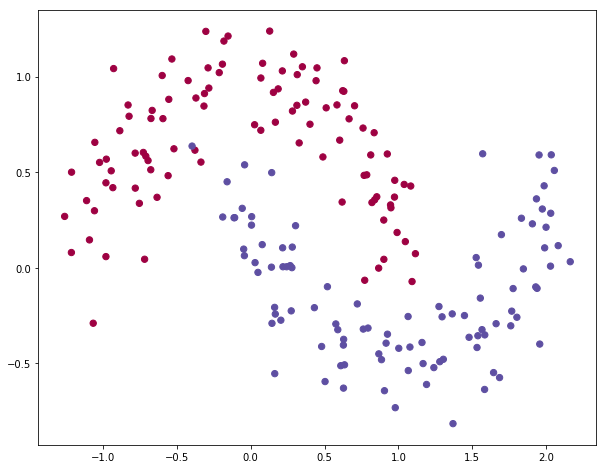

In [7]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.15)
y = y.reshape(200,1)
plt.scatter(X[:,0], X[:,1], s=40, c=y.flatten(), cmap=plt.cm.Spectral)

These two moons are to be seperated. To do so we first need to define some more helper functions to complete our model

In [8]:
def predict(model, x):
    '''
    Predicts y_hat as 1 or 0 for a given input X
    '''
    # Do forward pass
    c = forward_prop(model,x)
    #get y_hat
    y_hat = c['a2']
    
    # Turn values to either 1 or 0
    y_hat[y_hat > 0.5] = 1
    y_hat[y_hat < 0.5] = 0
    return y_hat

Next to the loss we will keep track of a new metric in this chapter. The accuracy. That is the percentage of examples our model classified correctly. Or more formally:

$$Acuracy = \frac{Correct Predictions}{Total Number of Examples}$$

There are different methods to evaluate a neural network but accuracy is the most common one. In python code it is calculated like this:

In [9]:
def calc_accuracy(model,x,y):
    '''
    Calculates the accuracy of the model given an input x and a correct output y.
    The accuracy is the percentage of examples our model classified correctly
    '''
    # Get total number of examples
    m = y.shape[0]
    # Do a prediction with the model
    pred = predict(model,x)
    # Ensure prediction and truth vector y have the same shape
    pred = pred.reshape(y.shape)
    # Calculate the number of wrong examples
    error = np.sum(np.abs(pred-y))
    # Calculate accuracy
    return (m - error)/m * 100

Parameter initialization works exactly like it did for the smaller logistic regressor. Pay attention to the matrix sizes of the layers.

In [10]:
def initialize_parameters(nn_input_dim,nn_hdim,nn_output_dim):
    '''
    Initializes weights with random number between -1 and 1
    Initializes bias with 0
    Assigns weights and parameters to model
    '''
    # First layer weights
    W1 = 2 *np.random.randn(nn_input_dim, nn_hdim) - 1
    
    # First layer bias
    b1 = np.zeros((1, nn_hdim))
    
    # Second layer weights
    W2 = 2 * np.random.randn(nn_hdim, nn_output_dim) - 1
    
    # Second layer bias
    b2 = np.zeros((1, nn_output_dim))
    
    # Package and return model
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    return model

Updating the parameters works the same way as it did with the smaller regressor.

In [11]:
def update_parameters(model,grads,learning_rate):
    '''
    Updates parameters accoarding to gradient descent algorithm
    See: https://en.wikipedia.org/wiki/Gradient_descent
    '''
    # Load parameters
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Update parameters
    W1 -= learning_rate * grads['dW1']
    b1 -= learning_rate * grads['db1']
    W2 -= learning_rate * grads['dW2']
    b2 -= learning_rate * grads['db2']
    
    # Store and return parameters
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    return model

After we have predefined all functions, the training routine of a larger network looks the same as the routine of a smaller network.

In [12]:
def train(model,X_,y_,learning_rate, num_passes=20000, print_loss=False):
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        cache = forward_prop(model,X_)
        #a1, probs = cache['a1'],cache['a2']
        # Backpropagation
        
        grads = backward_prop(model,cache,y)
        # Gradient descent parameter update
        # Assign new parameters to the model
        model = update_parameters(model=model,grads=grads,learning_rate=learning_rate)
    
        # Pring loss & accuracy every 100 iterations
        if print_loss and i % 100 == 0:
            y_hat = cache['a2']
            print('Loss after iteration',i,':',log_loss(y,y_hat))
            print('Accuracy after iteration',i,':',calc_accuracy(model,X_,y_),'%')
    
    return model

## Solving the problem with a bigger network
Now that we have created a bigger network, we will train it. Note how our bigger network gained a new hyper parameter: The size of the hidden layer is not given by the input or the output as the size of the other layers is. We can choose it as we like. We will experiment with this new hyper parameter later, for now we will use a hiden layer size of 3

In [13]:
# Hyper parameters
hiden_layer_size = 3
# I picked this value because it showed good results in my experiments
learning_rate = 0.01

In [14]:
# Initialize the parameters to random values. We need to learn these.
np.random.seed(0)
# This is what we return at the end
model = initialize_parameters(nn_input_dim=2, nn_hdim= hiden_layer_size, nn_output_dim= 1)
model = train(model,X,y,learning_rate=learning_rate,num_passes=1000,print_loss=True)

Loss after iteration 0 : 0.759087263427
Accuracy after iteration 0 : 86.5 %
Loss after iteration 100 : 0.257483903227
Accuracy after iteration 100 : 87.5 %
Loss after iteration 200 : 0.232960651205
Accuracy after iteration 200 : 91.0 %
Loss after iteration 300 : 0.0660746943562
Accuracy after iteration 300 : 98.5 %
Loss after iteration 400 : 0.0390488917674
Accuracy after iteration 400 : 99.0 %
Loss after iteration 500 : 0.0316235565793
Accuracy after iteration 500 : 99.5 %
Loss after iteration 600 : 0.0280834693446
Accuracy after iteration 600 : 99.5 %
Loss after iteration 700 : 0.0259672421939
Accuracy after iteration 700 : 99.5 %
Loss after iteration 800 : 0.0245330254066
Accuracy after iteration 800 : 99.5 %
Loss after iteration 900 : 0.0234800011904
Accuracy after iteration 900 : 99.5 %


Text(0.5,1,'Decision Boundary for hidden layer size 3')

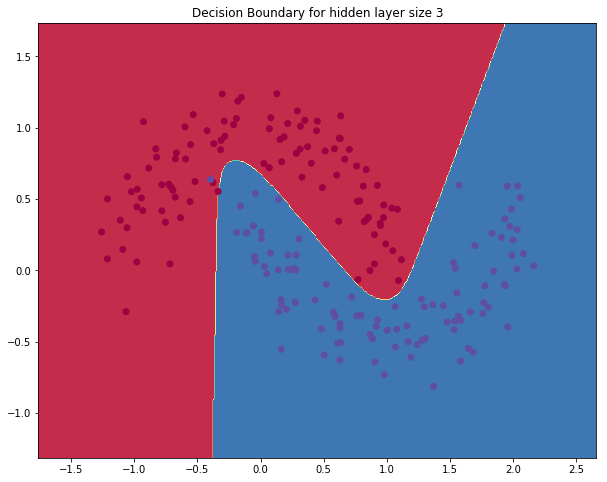

In [15]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model,x))
plt.title("Decision Boundary for hidden layer size 3")

## The signal and the noise
As you can see, our bigger network has no problems fitting this more complex function. It misses only a few dots. This is normal and not problematic, because our dataset includes noise. Noise are datapoints with wrong values that do not correspond to the actual distribution. Much like on the radio, where some sounds are part of the program (the signal) and some sounds are just errors in the transmission (the noise). In real live situations we encounter noise all the time. While we have to make sure that our models incorporate all the complexity of the signal, we want to avoid fitting it to noise. Let's see what happens if we turn up the noise on our dataset

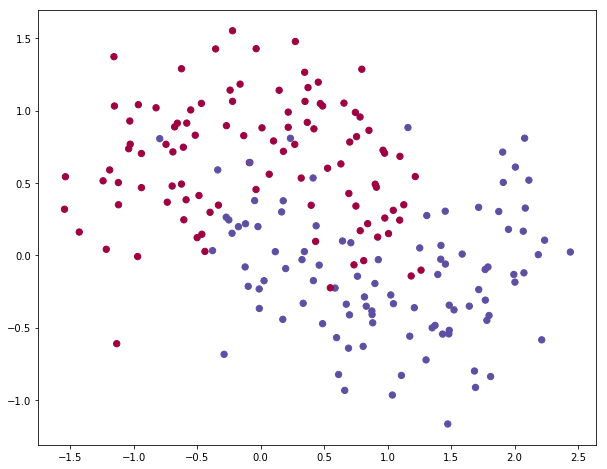

In [16]:
# Now with more noise
# Generate a dataset and plot it
np.random.seed(0)
# The data generator alows us to regulate the noise level
X, y = sklearn.datasets.make_moons(200, noise=0.3)
y = y.reshape(200,1)
plt.scatter(X[:,0], X[:,1], s=40, c=y.flatten(), cmap=plt.cm.Spectral)

This already looks significantly more messy, but the underlying distribution is still the same. The data still shows two moon shapes, although they are now much harder to see. We will now fit our model to this more noisy data.

In [17]:
# Hyper parameters
hiden_layer_size = 3
# I picked this value because it showed good results in my experiments
learning_rate = 0.01

# Initialize the parameters to random values. We need to learn these.
np.random.seed(0)
# This is what we return at the end
model = initialize_parameters(nn_input_dim=2, nn_hdim= hiden_layer_size, nn_output_dim= 1)
model = train(model,X,y,learning_rate=learning_rate,num_passes=1000,print_loss=True)

Loss after iteration 0 : 0.770832539775
Accuracy after iteration 0 : 82.5 %
Loss after iteration 100 : 0.348532383877
Accuracy after iteration 100 : 83.0 %
Loss after iteration 200 : 0.343649579095
Accuracy after iteration 200 : 84.0 %
Loss after iteration 300 : 0.327558064886
Accuracy after iteration 300 : 84.5 %
Loss after iteration 400 : 0.323983765178
Accuracy after iteration 400 : 85.5 %
Loss after iteration 500 : 0.322419107447
Accuracy after iteration 500 : 85.5 %
Loss after iteration 600 : 0.321468795413
Accuracy after iteration 600 : 85.5 %
Loss after iteration 700 : 0.320743912454
Accuracy after iteration 700 : 85.5 %
Loss after iteration 800 : 0.320121423988
Accuracy after iteration 800 : 85.5 %
Loss after iteration 900 : 0.319555418767
Accuracy after iteration 900 : 85.5 %


Text(0.5,1,'Decision Boundary for hidden layer size 3')

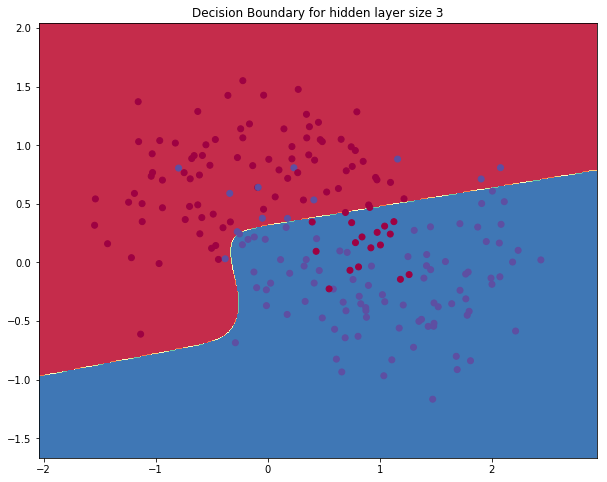

In [18]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model,x))
plt.title("Decision Boundary for hidden layer size 3")

As you can see, out model has a significantly harder time fitting this noisy distribution. In fact it seems like it does not find the actual descision boundary at all, but tries to approximate it in a way that fits as many training set points as possible. In the next experiment we will increase the hidden layer size to model a more complex function to this noisy dataset.

In [19]:
# Hyper parameters
hiden_layer_size = 500
# I picked this value because it showed good results in my experiments
learning_rate = 0.01

# Initialize the parameters to random values. We need to learn these.
np.random.seed(0)
# This is what we return at the end
model = initialize_parameters(nn_input_dim=2, nn_hdim= hiden_layer_size, nn_output_dim= 1)
model = train(model,X,y,learning_rate=learning_rate,num_passes=1000,print_loss=True)

Loss after iteration 0 : 13.0664888803
Accuracy after iteration 0 : 60.5 %
Loss after iteration 100 : 3.74374393035
Accuracy after iteration 100 : 79.5 %
Loss after iteration 200 : 3.53760611488
Accuracy after iteration 200 : 90.5 %
Loss after iteration 300 : 1.63043646399
Accuracy after iteration 300 : 74.0 %
Loss after iteration 400 : 0.763330577733
Accuracy after iteration 400 : 92.0 %
Loss after iteration 500 : 0.632788970866
Accuracy after iteration 500 : 87.5 %
Loss after iteration 600 : 2.60937563667
Accuracy after iteration 600 : 89.0 %
Loss after iteration 700 : 2.15894689569
Accuracy after iteration 700 : 89.0 %
Loss after iteration 800 : 1.25100434325
Accuracy after iteration 800 : 89.0 %
Loss after iteration 900 : 0.495409315387
Accuracy after iteration 900 : 93.5 %


Text(0.5,1,'Decision Boundary for hidden layer size 500')

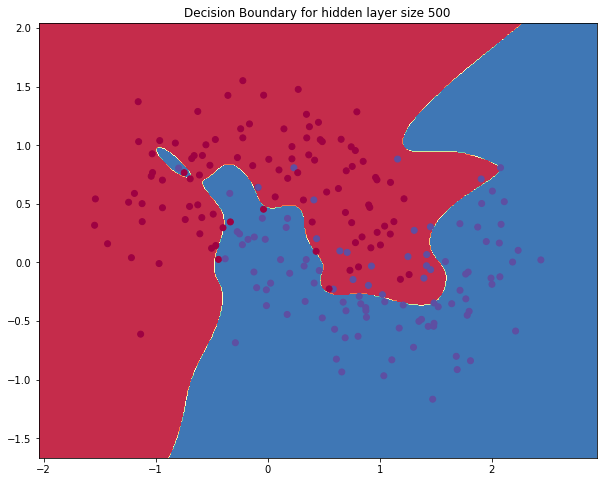

In [20]:
# Plot the decision boundary
# This might take a little while as our model is very big now
plot_decision_boundary(lambda x: predict(model,x))
plt.title("Decision Boundary for hidden layer size 500")

In the output from training you can see that the bigger model archieves a better accuracy and lower loss on the training set. However if you look at the decision boundary, you can see that it carves in many wired shapes just to accomodate a few dots. This kind of behavior is called overfitting. The model does too well on the traings set and failes to find generalizable findings. We can show this very easily by generating a second dataset. This dataset is generated with the exact same method as the first and follows the same general distribution. We will use our model to make a prediction for this new dataset it has not seen in training. This new dataset will be called the dev set, as we use it not to train but to tweak hyper parameters like the layer size on it.

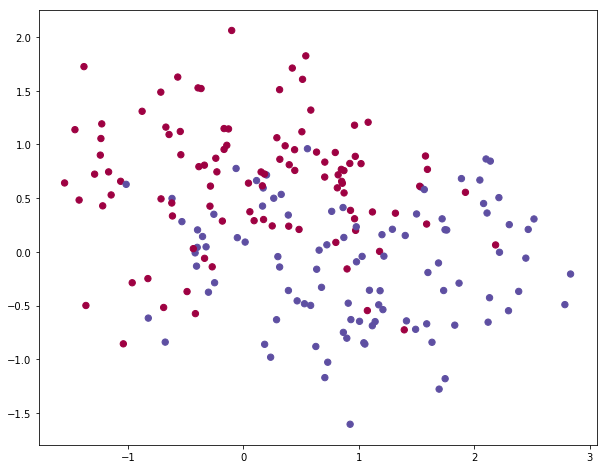

In [21]:
# Generate a dev dataset and plot it
np.random.seed(1)
# The data generator alows us to regulate the noise level
X_dev, y_dev = sklearn.datasets.make_moons(200, noise=0.5)
y_dev = y_dev.reshape(200,1)
plt.scatter(X_dev[:,0], X_dev[:,1], s=40, c=y_dev.flatten(), cmap=plt.cm.Spectral)

In [22]:
calc_accuracy(model=model,x=X_dev,y=y_dev)

75.5

The accuracy on our dev dataset is 78%, worse than it is on our training dataset. If the dev accuracy is significantly worse than the test accuracy then we might have overfit the training dataset. As an exercise you can try out different hidden layer sizes and see whether you can find one that matches the training and dev set very well.

## Summary
In this chapter you have seen how to build a deeper network. You have learned about the tanh activation function and  how the hidden layer size is also a hyper parameter that can be tuned. Additionally, you have learned about noise in data and overfitting. In the next chapter we will look at a new task, reading handwritten numbers.

## Exercise
You can find an Excel implementation of a two layer network in this weeks folder. Try adding another row to the data (you will have to modify X and y). What happens to the design of the network? What do you need to change? Hint: To run a formula that outputs multiple cells in excel, select the output range, enter the formula and hit CONTROL + SHIFT + ENTER